##### Copyright 2018 The TensorFlow Authors.

In [268]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-10-10 22:28:45.239612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 22:28:45.326626: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 22:28:45.723102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vanes/miniconda3/envs/tf-gpu-new/lib/
2024-10-10 22:28:45.723181: W tensorflow/compiler/xla

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-10-10 22:29:54.146097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 22:29:54.151250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 22:29:54.151287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib
from skimage import exposure

In [5]:

data_dir = pathlib.Path('/home/vanes/TA/MangoLeafBD')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4000


Here are some roses:

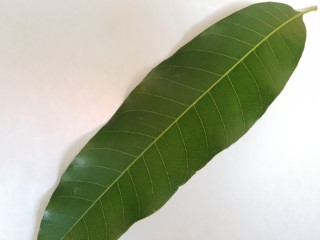

In [7]:
roses = list(data_dir.glob('Healthy/*'))
PIL.Image.open(str(roses[0]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 227
img_width = 227

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# import os
# import numpy as np
# import shutil
# from sklearn.model_selection import train_test_split

# # Set directories
# base_dir = '/home/vanes/TA/MangoLeafBD'  # Update to your base directory
# train_dir = '/home/vanes/TA/densenet_no_augmentation/train'
# val_dir = '/home/vanes/TA/densenet_no_augmentation/validation'
# test_dir = '/home/vanes/TA/densenet_no_augmentation/test'

# # Create directories for train, validation, and test
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Iterate through each class folder
# for class_name in os.listdir(base_dir):
#     class_path = os.path.join(base_dir, class_name)
    
#     if os.path.isdir(class_path):  # Check if it's a directory
#         # Get all images in the class directory
#         images = os.listdir(class_path)
#         images = [os.path.join(class_path, img) for img in images if img.endswith(('jpg', 'jpeg', 'png'))]  # Filter for image files
        
#         # Split into train and temp (for val and test)
#         train_images, temp_images = train_test_split(images, test_size=0.2, random_state=123)  # 80% train, 20% temp
#         # Split temp into val and test
#         val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=123)  # 10% val, 10% test
        
#         # Create class directories in train, val, and test
#         os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

#         # Move images to corresponding directories
#         for img in train_images:
#             shutil.copy(img, os.path.join(train_dir, class_name))
#         for img in val_images:
#             shutil.copy(img, os.path.join(val_dir, class_name))
#         for img in test_images:
#             shutil.copy(img, os.path.join(test_dir, class_name))

# print("Dataset split completed!")

Dataset split completed!


In [12]:
import tensorflow as tf

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Datasets loaded successfully!")


Found 3200 files belonging to 8 classes.


2024-10-10 22:30:41.357605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 22:30:41.358847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 22:30:41.358883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 22:30:41.358895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

Found 400 files belonging to 8 classes.
Found 400 files belonging to 8 classes.
Datasets loaded successfully!


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


## Visualize the data

Here are the first nine images from the training dataset:

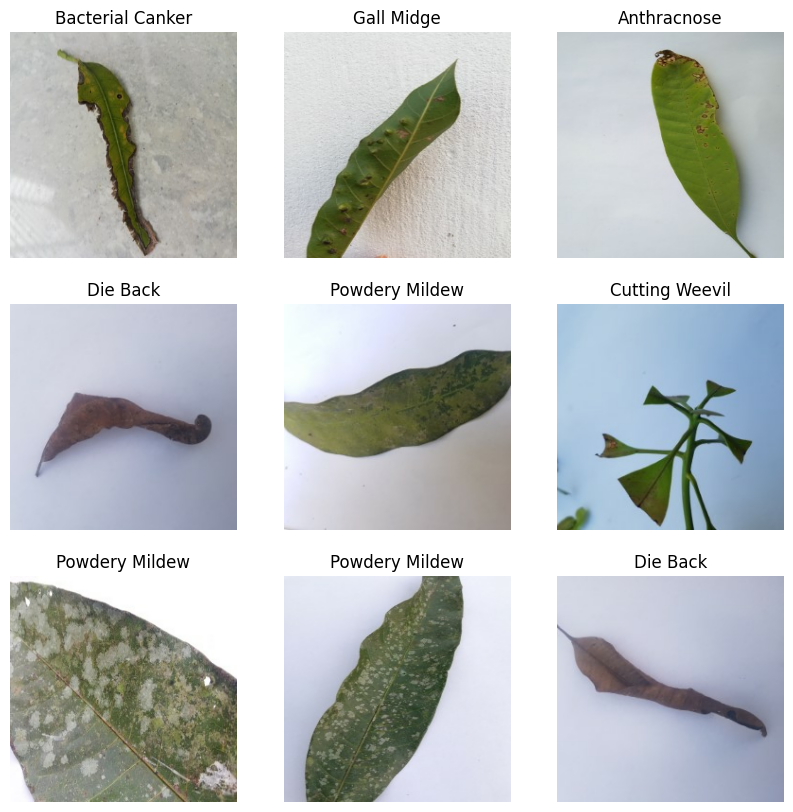

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [17]:
data_augmentation = keras.Sequential(
  [ 
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomFlip("vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

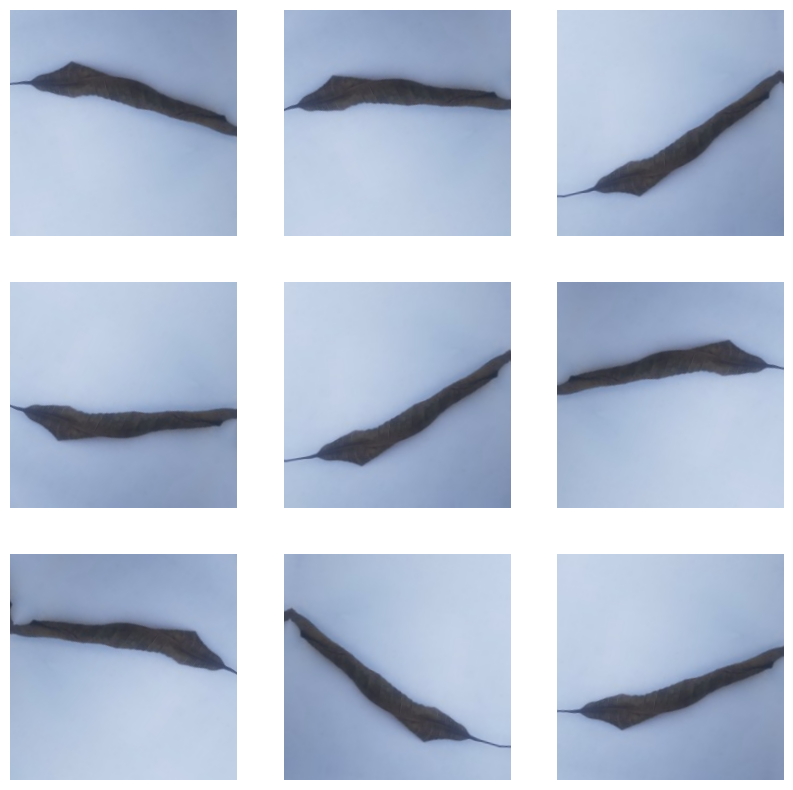

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


You will add data augmentation to your model before training in the next step.

Visualize a few augmented examples by applying data augmentation to the same image several times:

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [19]:
from tensorflow.keras import regularizers
num_classes = len(class_names)
from keras.applications import ResNet50, Xception,EfficientNetB0,DenseNet121
from keras import Model, layers
conv_base = DenseNet121(
    include_top=False,
    weights='imagenet')

conv_base.trainable = False

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Create a new model
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    conv_base,  # Include ResNet50 base model
    layers.GlobalAveragePooling2D(),  # Convert features to vectors
    layers.Dense(256, activation='relu'),  # Add fully connected layer
    # layers.Dense(800, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Output layer for classification
])

## Compile and train the model

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=60)
def lr_schedule(epoch):
    initial_learning_rate = 0.01
    if epoch < 1:
        return initial_learning_rate
    else:
        return initial_learning_rate * tf.math.exp(0.1 * (10 - epoch))
    
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.legacy.SGD(learning_rate=0.001), metrics=["accuracy"])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callback=[lr_scheduler, early_stopping]


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                      

In [22]:
epochs = 300
history = model.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=callback
)

Epoch 1/300


/home/vanes/miniconda3/envs/tf-gpu-new/lib/python3.8/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2024-10-10 22:32:17.780527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  1/100 [..............................] - ETA: 17:15 - loss: 2.3572 - accuracy: 0.0625

2024-10-10 22:32:22.836954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-10 22:32:22.851889: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x30ec79a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 22:32:22.851918: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-10-10 22:32:22.905519: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions

100/100 [==============================] - 33s 231ms/step - loss: 0.8451 - accuracy: 0.7837 - val_loss: 0.3922 - val_accuracy: 0.9325 - lr: 0.0100
Epoch 2/300
100/100 [==============================] - 21s 214ms/step - loss: 0.2593 - accuracy: 0.9378 - val_loss: 0.2035 - val_accuracy: 0.9450 - lr: 0.0246
Epoch 3/300
100/100 [==============================] - 21s 211ms/step - loss: 0.1389 - accuracy: 0.9681 - val_loss: 0.1321 - val_accuracy: 0.9750 - lr: 0.0223
Epoch 4/300
100/100 [==============================] - 21s 212ms/step - loss: 0.1030 - accuracy: 0.9769 - val_loss: 0.1030 - val_accuracy: 0.9750 - lr: 0.0201
Epoch 5/300
100/100 [==============================] - 21s 214ms/step - loss: 0.0873 - accuracy: 0.9794 - val_loss: 0.0844 - val_accuracy: 0.9825 - lr: 0.0182
Epoch 6/300
100/100 [==============================] - 21s 208ms/step - loss: 0.0744 - accuracy: 0.9834 - val_loss: 0.0794 - val_accuracy: 0.9850 - lr: 0.0165
Epoch 7/300
100/100 [==============================] - 21s

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

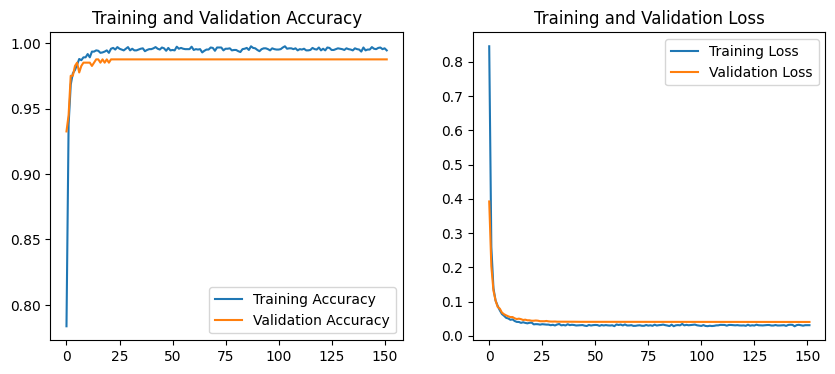

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(152)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [24]:
y_pred = model.predict(val_ds)


13/13 [==============================] - 3s 114ms/step


/home/vanes/TA/densenet_no_augmentation/test/Cutting Weevil/20211011_161502 (Custom) (Custom).jpg
1/1 [==============================] - 3s 3s/step
This image most likely belongs to Cutting Weevil with a 96.96 percent confidence.


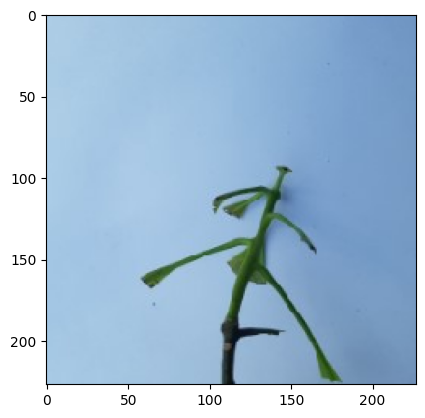

In [25]:
data_dir = pathlib.Path('/home/vanes/TA/densenet_no_augmentation/')
roses = list(data_dir.glob('test/Cutting Weevil/*'))
# sunflower_path = pathlib.Path('/home/vanes/TA/gallmidge.png')
img = tf.keras.utils.load_img(
    str(roses[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img2 = tf.keras.utils.load_img(
    "/home/vanes/TA/densenet_no_augmentation/test/Cutting Weevil/20211011_161243 (Custom).jpg", target_size=(img_height, img_width)
)
print(str(roses[3]))
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions = model.predict(img_array2)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)) 
)

plt.figure()
plt.imshow(img2) 
plt.show() 

/home/vanes/TA/densenet_no_augmentation/test/Anthracnose/20211008_125104 (Custom).jpg
1/1 [==============================] - 0s 23ms/step
This image most likely belongs to Anthracnose with a 99.92 percent confidence.


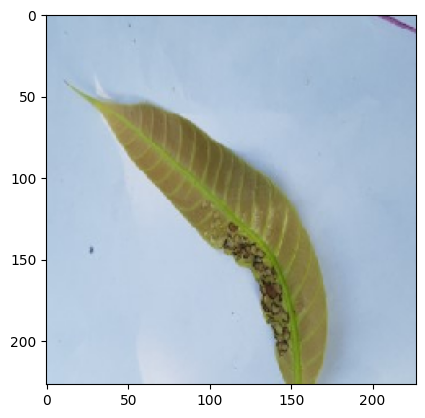

In [27]:
data_dir = pathlib.Path('/home/vanes/TA/densenet_no_augmentation/')
roses = list(data_dir.glob('test/Anthracnose/*'))
# sunflower_path = pathlib.Path('/home/vanes/TA/gallmidge.png')
img = tf.keras.utils.load_img(
    str(roses[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img2 = tf.keras.utils.load_img(
    "/home/vanes/TA/densenet_no_augmentation/test/Anthracnose/20211008_124312 (Custom).jpg", target_size=(img_height, img_width)
)
print(str(roses[3]))
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions = model.predict(img_array2)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)) 
)

plt.figure()
plt.imshow(img2) 
plt.show() 

1/1 [==============================] - 0s 23ms/step


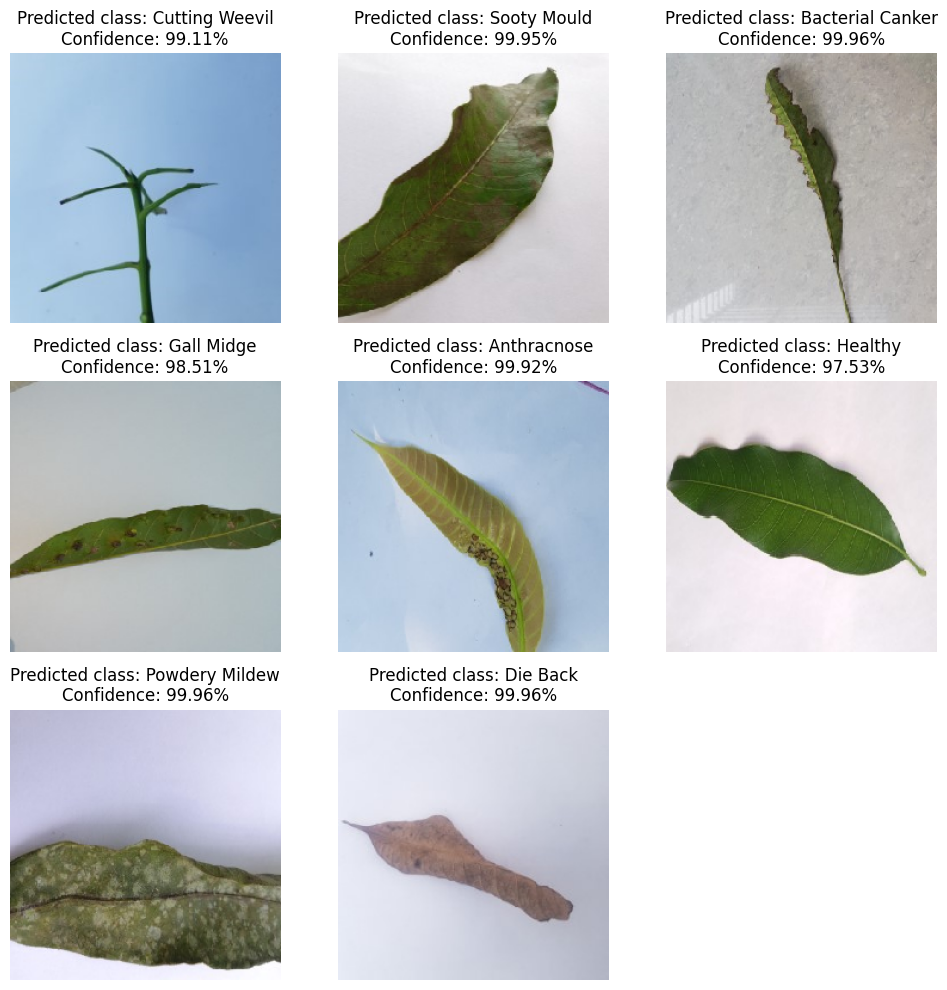

Image: 20211011_161141 (Custom) (Custom).jpg, Predicted class: Cutting Weevil, Confidence: 99.11%
Image: IMG_20211212_143337 (Custom).jpg, Predicted class: Sooty Mould, Confidence: 99.95%
Image: IMG_20211106_141113 (Custom).jpg, Predicted class: Bacterial Canker, Confidence: 99.96%
Image: IMG_20211106_165515 (Custom).jpg, Predicted class: Gall Midge, Confidence: 98.51%
Image: 20211008_124312 (Custom).jpg, Predicted class: Anthracnose, Confidence: 99.92%
Image: 20211231_154925 (Custom).jpg, Predicted class: Healthy, Confidence: 97.53%
Image: IMG_20211107_125836 (Custom).jpg, Predicted class: Powdery Mildew, Confidence: 99.96%
Image: 20211129_163809 (Custom).jpg, Predicted class: Die Back, Confidence: 99.96%


In [28]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import random

# Assuming `model` and `class_names` are defined

# Define the directory containing images
data_dir = pathlib.Path('/home/vanes/TA/densenet_no_augmentation/test')

# List of subdirectories (classes)
subdirectories = [subdir for subdir in data_dir.glob('*') if subdir.is_dir()]

# Randomly select 9 images from each subdirectory
image_paths = []
for subdir in subdirectories:
    images_in_subdir = list(subdir.glob('*'))
    selected_images = random.sample(images_in_subdir, min(len(images_in_subdir), 1))
    image_paths.extend(selected_images)

# Function to preprocess and predict an image
def predict_image(img_path, model, class_names):
    img = tf.keras.utils.load_img(img_path, target_size=(227, 227))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    score = predictions[0]

    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    return predicted_class, confidence, img

# List to store results
results = []

# Plotting settings
plt.figure(figsize=(10, 10))

# Iterate over each image path and display
for i, img_path in enumerate(image_paths):
    # Predict image
    predicted_class, confidence, img = predict_image(str(img_path), model, class_names)
    
    # Store results
    results.append((img_path.name, predicted_class, confidence))
    
    # Display image and prediction in subplot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Display results
for result in results:
    print(f"Image: {result[0]}, Predicted class: {result[1]}, Confidence: {result[2]:.2f}%")


In [29]:
print(np.argmax(predictions, axis=1))

[0]


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

# Assuming y_val and y_pred are numpy arrays
y_val_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)  # Get true labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

cm = confusion_matrix(y_val_true, y_pred_classes)

In [31]:
# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])  # Precision for class 1 (positive class)
specificity = cm[0, 0] / np.sum(cm[0, :])  # Specificity for class 0 (assuming binary classification)

# Calculate F-score
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
f_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F-score: {f_score:.3f}")
print(classification_report(y_val_true, y_pred_classes))

Accuracy: 0.988
Precision: 1.000
Specificity: 1.000
F-score: 0.990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       0.98      0.96      0.97        50
           5       0.98      0.98      0.98        50
           6       0.98      1.00      0.99        50
           7       0.96      0.98      0.97        50

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



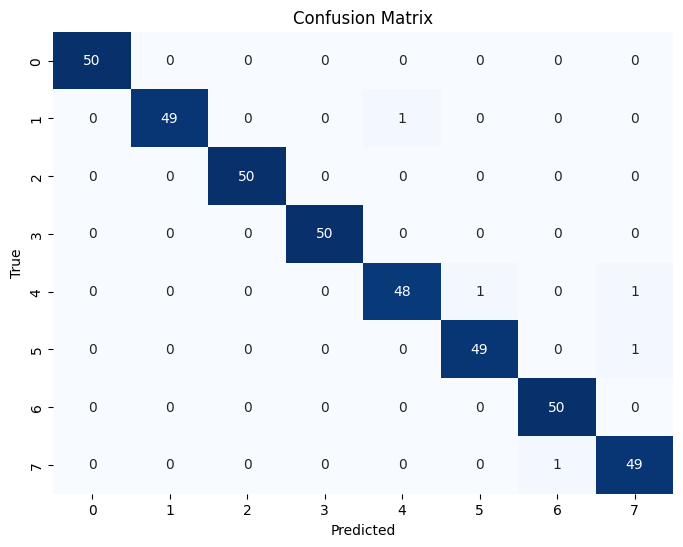

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [34]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('modelNOCLAHE.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsq59qjsg/assets


INFO:tensorflow:Assets written to: /tmp/tmpsq59qjsg/assets
2024-10-10 23:33:34.312025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-10-10 23:33:34.312089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-10-10 23:33:34.319379: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsq59qjsg
2024-10-10 23:33:34.360220: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-10-10 23:33:34.360278: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsq59qjsg
2024-10-10 23:33:34.715033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-10-10 23:33:34.783774: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-10-10 23:33:35.641015: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = predictions_lite

ValueError: Invalid Input name (sequential_1_input) for SignatureDef

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

NameError: name 'score_lite' is not defined

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).